# Disaggregation - Combinatorial Optimisation #

##Customary imports##

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from os.path import join
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
#import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict, show_versions
from nilmtk.metrics import f1_score
#import seaborn as sns
#sns.set_palette("Set3", n_colors=12)

import warnings
warnings.filterwarnings("ignore") #suppress warnings, comment out if warnings required

## show versions for any diagnostics##

In [2]:
#uncomment if required
#show_versions()


##Load dataset##

In [3]:
data_dir = '/Users/GJWood/nilm_gjw_data/HDF5/'
gjw = DataSet(join(data_dir, 'nilm_gjw_data.hdf5'))
print('loaded ' + str(len(gjw.buildings)) + ' buildings')
building_number=1

loaded 1 buildings


#Let us perform our analysis on selected 2 days##

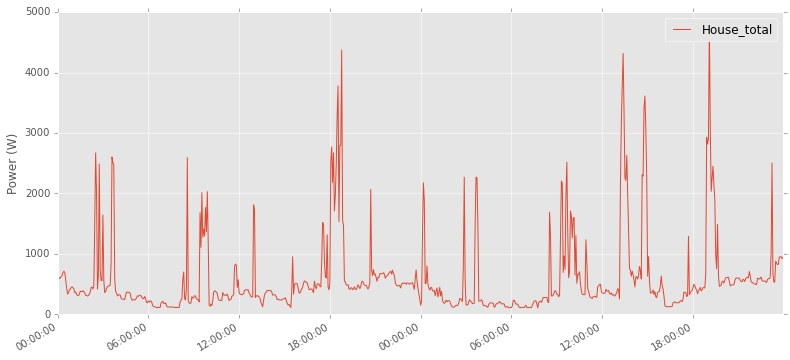

In [4]:
gjw.store.window = TimeFrame(start='2015-09-03 00:00:00+01:00', end='2015-09-05 00:00:00+01:00')
gjw.set_window = TimeFrame(start='2015-09-03 00:00:00+01:00', end='2015-09-05 00:00:00+01:00')
elec = gjw.buildings[building_number].elec
mains = elec.mains()
mains.plot()
#plt.show()

### check sections are good ###

In [5]:
elec.mains().good_sections()

[TimeFrame(start='2015-09-03 00:00:00+01:00', end='2015-09-05 00:00:00+01:00', empty=False)]

### Select and check dataframe ###

In [6]:
house = elec['fridge'] #only one meter so any selection will do
df = house.load().next() #load the first chunk of data into a dataframe
df.info() #check that the data is what we want (optional)
#note the data has two columns and a time index


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172800 entries, 2015-09-03 00:00:00+01:00 to 2015-09-04 23:59:59+01:00
Data columns (total 2 columns):
(power, reactive)    172800 non-null float32
(power, active)      172800 non-null float32
dtypes: float32(2)
memory usage: 2.6 MB


In [7]:
df.head()

physical_quantity            power       
type                      reactive active
2015-09-03 00:00:00+01:00        0    610
2015-09-03 00:00:01+01:00        0    610
2015-09-03 00:00:02+01:00        0    610
2015-09-03 00:00:03+01:00        0    610
2015-09-03 00:00:04+01:00        0    610

In [8]:
df.tail()

physical_quantity            power       
type                      reactive active
2015-09-04 23:59:55+01:00      393    857
2015-09-04 23:59:56+01:00      393    857
2015-09-04 23:59:57+01:00      393    857
2015-09-04 23:59:58+01:00      393    857
2015-09-04 23:59:59+01:00      393    857

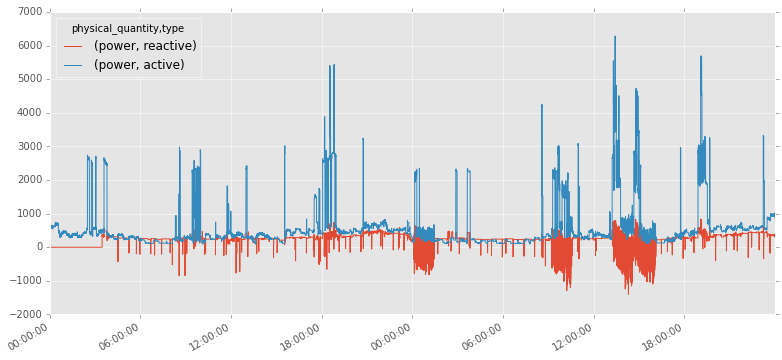

In [9]:
df.plot()
#plt.show()

##Training##
We'll now do the training from the aggregate data. The algorithm segments the time series data into steady and transient states. Thus, we'll first figure out the transient and the steady states. Next, we'll try and pair the on and the off transitions based on their proximity in time and value.

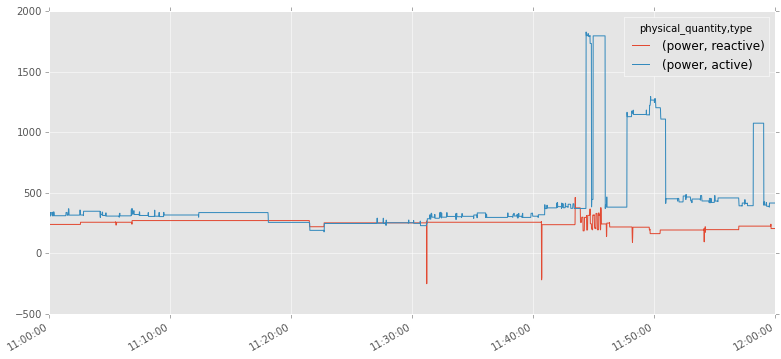

In [10]:
df.ix['2015-09-03 11:00:00+01:00':'2015-09-03 12:00:00+01:00'].plot()# select a time range and plot it
#plt.show()

In [13]:
co = CombinatorialOptimisation()
co.train(elec,cols=[('power','active')])


IndexError: list index out of range

In [11]:
co.steady_states.head()


,active average,reactive average
2015-09-03 00:20:37+01:00,701.376344,0
2015-09-03 00:24:02+01:00,659.000000,0
2015-09-03 00:34:00+01:00,553.000000,0
2015-09-03 00:39:34+01:00,321.000000,0
2015-09-03 01:16:31+01:00,314.000000,0


In [12]:
co.steady_states.tail()

,active average,reactive average
2015-09-04 23:27:45+01:00,822.20000,393.000000
2015-09-04 23:27:55+01:00,898.00000,392.962963
2015-09-04 23:28:49+01:00,898.00000,304.800000
2015-09-04 23:28:54+01:00,897.96129,395.083871
2015-09-04 23:41:34+01:00,967.00000,342.000000


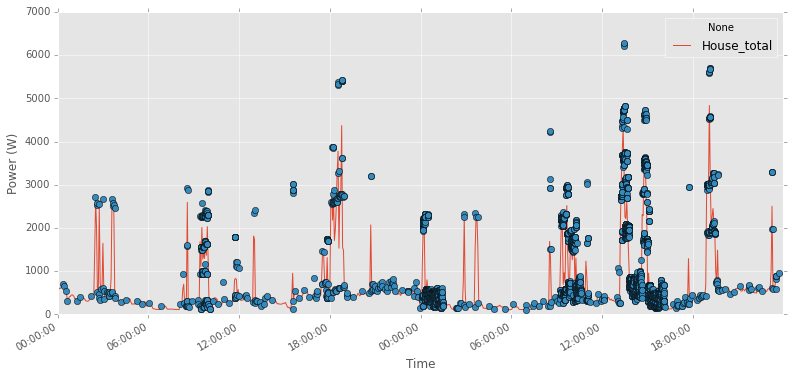

In [13]:
ax = mains.plot()
co.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");
#plt.show()

In [14]:
disag_filename = join(data_dir, 'disag_gjw_CO.hdf5')
output = HDFDataStore(disag_filename, 'w')
co.disaggregate(mains,output)
output.close()

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


Exception: Data must be 1-dimensional

In [ ]:
disag_hart = DataSet(disag_filename)
disag_hart_elec = disag_hart.buildings[building].elec

In [ ]:
from nilmtk.metrics import f1_score
f1_hart= f1_score(disag_hart_elec, test_elec)
f1_hart.index = disag_hart_elec.get_labels(f1_hart.index)
f1_hart.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("Hart");